In [6]:
# import the needed packages
import pandas as pd
import stlearn as st
import scanpy as sc
import scanpy.external as sce
# import squidpy as sq
import matplotlib.pyplot as plt
import subprocess
import numpy as np
import anndata as ad
from anndata import AnnData
import matplotlib as mpl
import seaborn as sns
import monkeybread as mb
import sys

from collections import OrderedDict

import time
import os, wget

import cudf
import cupy as cp

from cuml.decomposition import PCA

sys.path.insert(1, '../rapidgenomics/notebooks')
import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

# make sure that we are in the right directory
print(os.getcwd())

# set the filenames we are looking at
filenames = ["S17_7722_E4", "S1614455_C21"]
pop_samples = ['Haitian', 'Haitian']

/mnt/plummergrp/QuPath_0.4.4/BrCa


In [ ]:
for i in range(len(filenames)):

    df = pd.read_csv("./"+filenames[i]+".txt", sep='\t', lineterminator='\n')

    # create the cell matrix
    df_mat = df[df.columns[df.columns.str.contains("Cell: Mean")]]
    # leave only protein names
    df_mat.columns = df_mat.columns.str.replace(': Cell: Mean', '')
    # drop DAP1 because it is inconsequential to the downstream analysis
    # df_mat = df_mat.drop(columns=["DAPI"])
    # need to increase the index by 1 so that it doesn't start at 0
    df_mat.index = df_mat.index + 1
    # save it as a csv
    df_mat.to_csv("./"+filenames[i]+"_matrix.csv", index=True)

    # create the metadata file
    df_meta = df[['Centroid X µm','Centroid Y µm','Nucleus: Area µm^2']].copy()
    # calculate the cytoplasm as the cell minus the nucleus
    df_meta.loc[:, 'Cytoplasm: Area µm^2'] = df['Cell: Area µm^2'].sub(df['Nucleus: Area µm^2'])
    # need to increase the index by 1 so that it doesn't start at 0
    df_meta.index = df_meta.index + 1
    # save it as a csv
    df_meta.to_csv("./"+filenames[i]+"_metadata.csv", index=True)

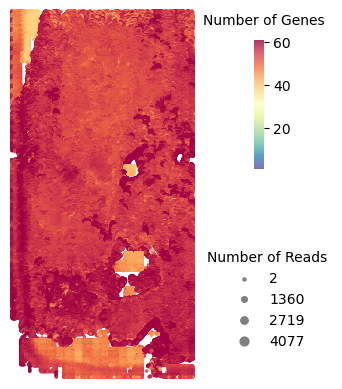

AnnData object with n_obs × n_vars = 1015567 × 61
    obs: 'imagecol', 'imagerow'
    uns: 'spatial'
    obsm: 'spatial'


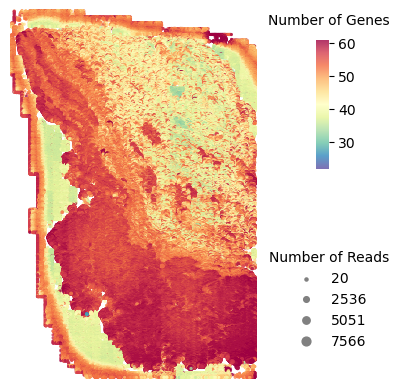

AnnData object with n_obs × n_vars = 1537975 × 61
    obs: 'imagecol', 'imagerow'
    uns: 'spatial'
    obsm: 'spatial'


In [11]:
# load the data into Anndata
adatas = []

for i in range(len(filenames)):
    count_matrix = pd.read_csv('./'+filenames[i]+'_matrix.csv', index_col=0)
    spatial = pd.read_csv('./'+filenames[i]+'_metadata.csv', index_col=0)
    spatial = spatial[['Centroid X µm', 'Centroid Y µm']]
    spatial = spatial.rename(columns={'Centroid X µm': 'imagecol', 'Centroid Y µm': 'imagerow'})

    adatas.append(st.create_stlearn(count=count_matrix,spatial=spatial,library_id="Sample_test", scale=1,background_color="white"))
    st.pl.QC_plot(adatas[i])
    print(adatas[i])

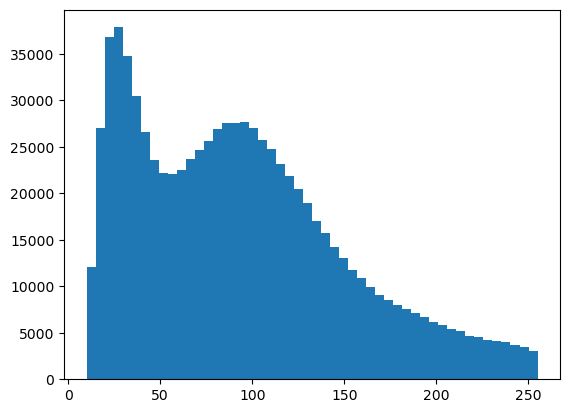

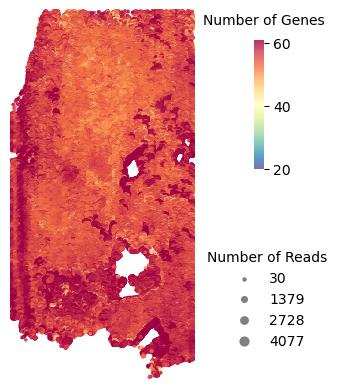

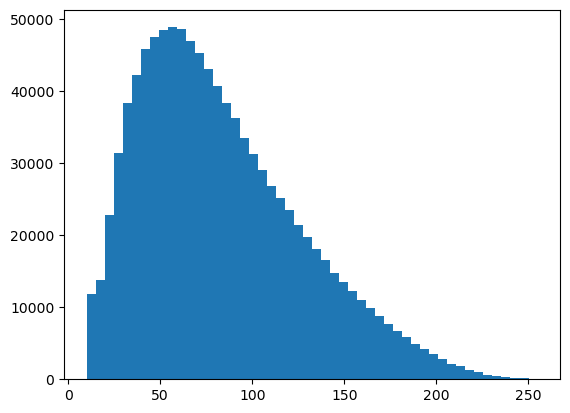

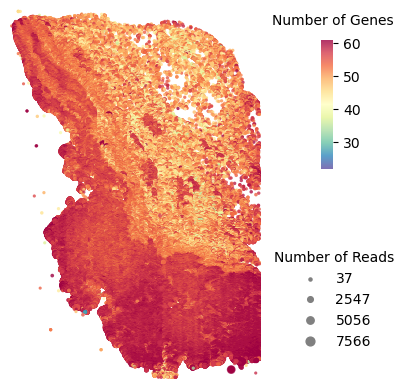

In [12]:
# remove stardist artifacts using DAPI expression level
n_bins = 50
for i in range(len(filenames)):
    adatas[i] = adatas[i][adatas[i][:, 'DAPI'].X > 10, :]
    # find out histogram of DAPI expression
    plt.hist(adatas[i].X[:,0], n_bins)
    plt.show()
    st.pl.QC_plot(adatas[i])

In [13]:
# remove DAPI from the anndatas
genes = pd.Index.tolist(adatas[i].var_names)
genes = genes[1::]
for i in range(len(filenames)):
    adatas[i] = adatas[i][:,genes]
    print(adatas[i].var_names)

Index(['CD8', 'HLA-A', 'CD4', 'pNRF2', 'CD20', 'ER', 'Keratin 14', 'Vimentin',
       'PR', 'E-cadherin', 'CD31', 'PDL1', 'CD45RO', 'Keratin19', 'CD3e',
       'IDO1', 'SMA', 'GranzymeB', 'Keratin5', 'CollagenIV', 'Podoplanin',
       'CD14', 'FoxP3', 'ASCT2', 'CD45', 'tp63', 'CD44', 'HLA-DR', 'PD1',
       'ERG', 'b-catenin1', 'HER2', 'CD57', 'Keratin8', 'CD163', 'GATA3',
       'S100A4', 'CD68', 'HIF1A', 'Keratin18', 'FoxA1', 'LaminB1', 'CD227',
       'H2AX', 'PCNA', 'Keratin17', 'CPT1A', 'BAK', 'PARP', 'Keratin7',
       'Dnmt1', 'FAP', 'Glut1', 'p53', 'MMP9', 'Cytokeratin6', 'CD11b', 'Ki67',
       'Pan-Cytokeratin', 'CD66b'],
      dtype='object')
Index(['CD8', 'HLA-A', 'CD4', 'pNRF2', 'CD20', 'ER', 'Keratin 14', 'Vimentin',
       'PR', 'E-cadherin', 'CD31', 'PDL1', 'CD45RO', 'Keratin19', 'CD3e',
       'IDO1', 'SMA', 'GranzymeB', 'Keratin5', 'CollagenIV', 'Podoplanin',
       'CD14', 'FoxP3', 'ASCT2', 'CD45', 'tp63', 'CD44', 'HLA-DR', 'PD1',
       'ERG', 'b-catenin1', 'HER2', 

# find all the gene names
genes = pd.Index.tolist(adata.var_names)

# produce gene expression plots
for gene in genes:
    st.pl.gene_plot(adata, gene_symbols=gene)

In [ ]:
# clr normalization method courtesy of maximz
# https://github.com/scverse/scanpy/issues/1208
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [ ]:
# normalize the datasets individually
for i in range(len(filenames)):
    st.pp.filter_genes(adatas[i],min_cells=1)
    clr_normalize_each_cell(adatas[i])

# combine the datasets
adata = adatas[0]
for i in range(len(filenames)-1):
    adata = adata.concatenate(adatas[i+1])
print(adata.obs['batch'])

# save the anndata!
adata.write_h5ad('./session_file.h5ad')

# copy anndata for other batch correction techniques
# adata_bbknn = adata.copy()
# adata_scanorama = adata.copy()

new way of running harmonypy using a python script instead
first run the following commands in terminal:
export NUM_THREADS=1
export OPENBLAS_NUM_THREADS=1
export OMP_NUM_THREADS=1

now run the python script
python RunHarmony.py

CLUSTERING!

In [7]:
# set up GPU
import rmm

rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)

cp.cuda.set_allocator(rmm.allocators.cupy.rmm_cupy_allocator)

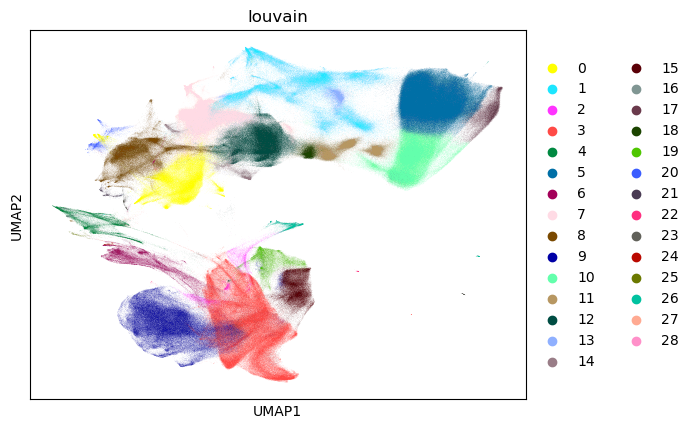

CPU times: user 6min 8s, sys: 43.5 s, total: 6min 51s
Wall time: 6min 41s


In [8]:
%%time
# running clustering using GPU
# load anndata
adata = ad.read_h5ad('./session_file_harmony.h5ad')
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
# initialize parameters
n_neighbors = 30
knn_n_pcs = 50
umap_min_dist = 0.3 
umap_spread = 1.0
# run neighbors
sc.pp.neighbors(adata, n_neighbors=n_neighbors,n_pcs=knn_n_pcs, method='rapids', use_rep='X_pca')
# run umap
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')
# run louvain
sc.tl.louvain(adata, flavor='rapids', resolution=0.5)
# plot
sc.pl.umap(adata, color=['louvain'], cmap='viridis', show=False)
plt.show()


Scale step is finished in adata.X


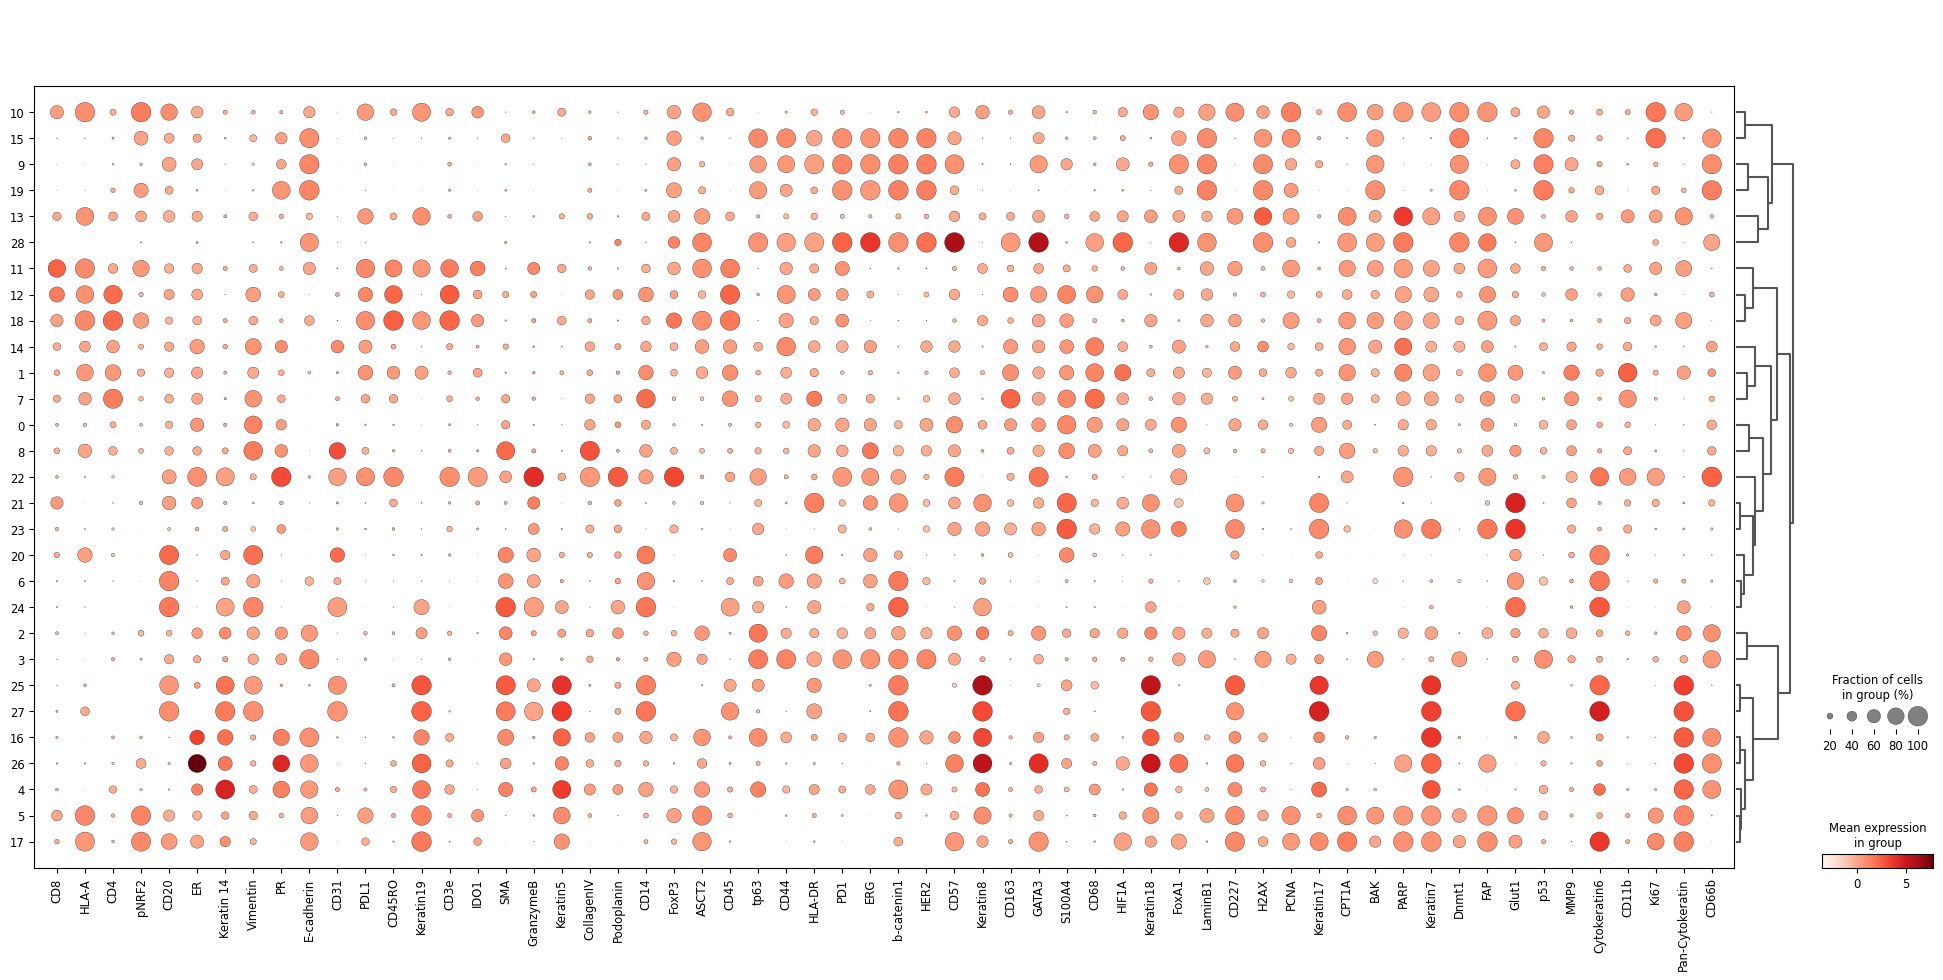

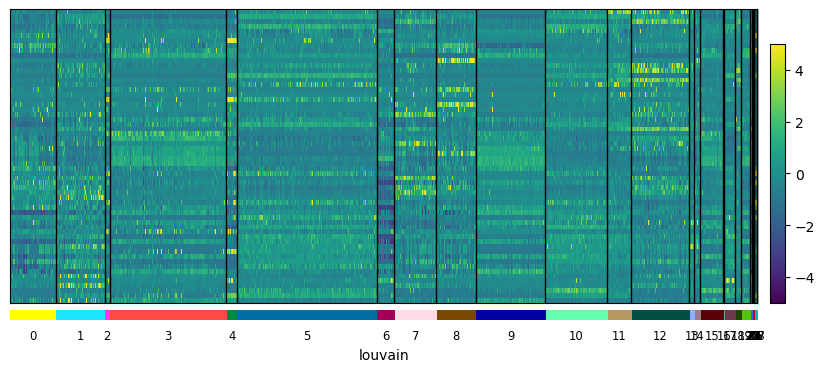

In [9]:
# find all the gene names
genes = pd.Index.tolist(adata.var_names)

# scale for the dotplot
adata_scaled = adata.copy()
st.pp.scale(adata_scaled)

# create gene expression dotplot
sc.pl.dotplot(adata_scaled, genes, groupby='louvain', dendrogram=True)

# create gene expression heatmap
sc.pl.heatmap(adata_scaled, genes, groupby='louvain', swap_axes=True, vmin=-5, vmax=5)

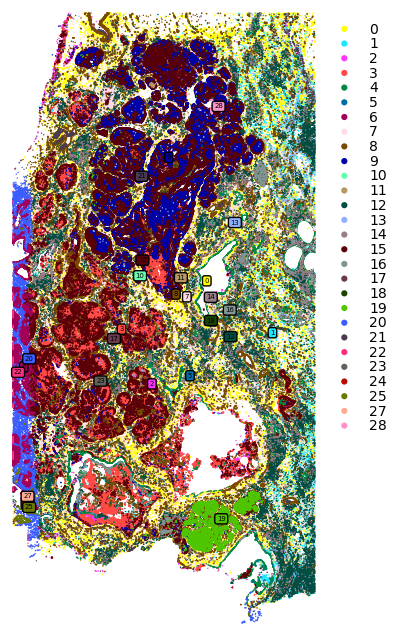

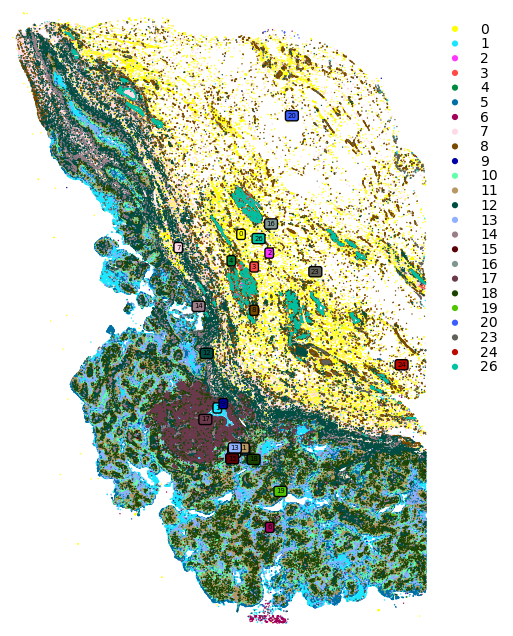

In [14]:
# map the clusters onto the tissues
# load anndata
# adata = ad.read_h5ad('./session_file_harmony.h5ad')

adata_samples = []
for i in range(len(filenames)):
    adata_samples.append(adata[adata.obs['batch'] == str(i)])
    # adata_samples.append(adata[adata.obs['batch'] == "sample"+str(i)])  
    adata_samples[i].uns['spatial'] = adatas[i].uns['spatial']
    st.pl.cluster_plot(adata_samples[i],use_label="louvain", show_cluster_labels=True, size=1, figsize=(8, 8))
    plt.show()


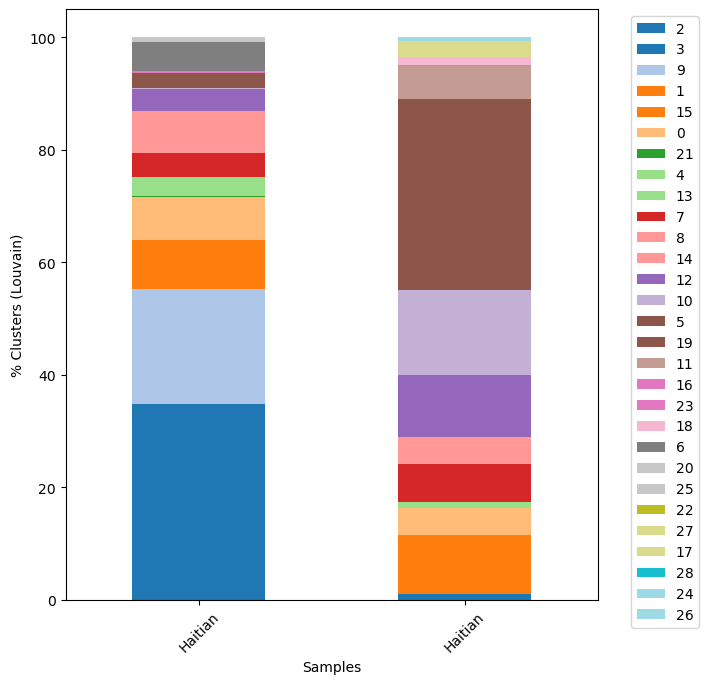

In [20]:
# proportion of clusters in each sample
plt_data_samples = []
for i in range(len(filenames)):
    plt_data_sample={}
    for v in adata_samples[i].obs['louvain'].unique():
        plt_data_sample[v]=adata_samples[i][adata_samples[i].obs['louvain']==v].shape[0]/adata_samples[i].shape[0]*100
    plt_data_samples.append(plt_data_sample)

df = pd.DataFrame.from_dict(plt_data_samples[0],orient='index')  
for i in range(len(filenames)-1):
    df = pd.concat([df, pd.DataFrame.from_dict(plt_data_samples[i+1],orient='index')], axis=1)  
df.columns = pop_samples

df.T.plot(kind='bar', stacked=True, colormap='tab20', figsize=(7,7))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.xlabel("Samples")
plt.xticks(rotation=45)
plt.ylabel("% Clusters (Louvain)")
plt.show()

NICHE NEIGHBORHOOD!!

In [ ]:
# neighbourhood analysis
# set up
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor="white")

for i in range(len(filenames)):
    sq.gr.spatial_neighbors(adata_samples[i])

    # neighbourhood enrichment
    sq.gr.nhood_enrichment(adata_samples[i], cluster_key="louvain")
    sq.pl.nhood_enrichment(adata_samples[i], cluster_key="louvain", method="average", figsize=(5, 5))
    plt.show()

    # interaction matrix
    sq.gr.interaction_matrix(adata_samples[i], cluster_key="louvain")
    sq.pl.interaction_matrix(adata_samples[i], cluster_key="louvain", method="average", figsize=(5, 5))
    plt.show()


In [ ]:
# niche analysis of the combined data 
niche_subtypes = []
other_cell_types = [] #['8','3']

for cell, ct in zip(adata.obs.index, adata.obs['louvain']):
    if ct in other_cell_types:
        niche_subtypes.append('malignant/other')
    else:
        niche_subtypes.append(ct)
adata.obs['niche_subtypes'] = niche_subtypes
adata.obs['niche_subtypes'] = adata.obs['niche_subtypes'].astype('category')

print("Cell subtypes considered in niche analysis:")
print(set(adata.obs['niche_subtypes']))

adata.obsm['X_spatial'] = adata.obsm['spatial']
immune_mask = ~adata.obs['niche_subtypes'].isin([
    'malignant/other'
])

# Compute niches
adata_neighbors = mb.calc.cellular_niches(
    adata,
    cell_type_key='niche_subtypes',
    radius=75,
    normalize_counts=True,
    standard_scale=True,
    clip_min=-5,
    clip_max=5,
    n_neighbors=100,
    resolution=0.25,
    min_niche_size=300,
    key_added='niche',
    non_niche_value='malignant/other',
    mask=immune_mask
)

# Subset cells
adata_neighbors_sub = sc.pp.subsample(
    adata_neighbors, fraction=1/2, copy=True
)

# Generate UMAP plots
sc.tl.umap(adata_neighbors_sub,  n_components=2)
sc.pl.umap(
    adata_neighbors_sub, 
    color='niche_subtypes', 
    palette=sc.pl.palettes.vega_20_scanpy,
    projection='2d'
)
sc.pl.umap(
    adata_neighbors_sub, 
    color='niche', 
    palette=sc.pl.palettes.vega_20_scanpy,
    projection='2d'
)

print(adata)

In [ ]:
# Map each niche to a color so that plots are consistent
niche_to_color = {
    val: mb.plot.monkey_palette[i]
    for i, val in enumerate(sorted(set(adata_neighbors.obs['niche'])))
}

adata_niches = []
for i in range(len(filenames)):
    adata_niches.append(adata[adata.obs['batch'] == str(i)])

    fig, ax = plt.subplots(1,1,figsize=(10,10))
    sc.pl.embedding(
        adata_niches[i],
        "spatial",
        color = 'niche',
        palette=niche_to_color,
        size=1,
        ax=ax,
        show=False,
    )
    plt.show()

In [ ]:
# find all the gene names
genes = pd.Index.tolist(adata.var_names)

# scale the data
adata_niches_scaled = []
for i in range(len(filenames)):
    adata_niches_scaled.append(adata_niches[i].copy())
    st.pp.scale(adata_niches_scaled[i], zero_center=True)

    # create gene expression heatmap
    sc.pl.heatmap(adata_niches_scaled[i], genes, groupby='niche', show_gene_labels=True, swap_axes=True, vmin=-5, vmax=5)

In [ ]:
# proportion of niches in each sample
plt_data_niches = []
for i in range(len(filenames)):
    plt_data_niche = {}
    for v in adata_niches[i].obs['niche'].unique():
        plt_data_niche[v]=adata_niches[i][adata_niches[i].obs['niche']==v].shape[0]/adata_niches[i].shape[0]*100
    plt_data_niches.append(plt_data_niche)


df = pd.DataFrame.from_dict(plt_data_niches[0],orient='index')  
for i in range(len(filenames)-1):
    df = pd.concat([df, pd.DataFrame.from_dict(plt_data_niches[i+1],orient='index')], axis=1)  
df.columns = pop_samples

df.T.plot(kind='bar', stacked=True, colormap='tab20', figsize=(8,8))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.xlabel("Samples")
plt.xticks(rotation=45)
plt.ylabel("% Niches")
plt.show()

ASTIR CELL TYPING!!!

In [ ]:
# load in the astir generated cell types and plot onto the tissues
celltypes = []
for i in range(len(filenames)):
    celltypes.append(pd.read_csv('./'+filenames[i]+'_cell-types.csv', index_col=0)['cell_type'])

for i in range(len(filenames)):
    adatas[i].obs['celltypes'] = celltypes[i].to_numpy()
    adatas[i].obs['celltypes'] = adatas[i].obs['celltypes'].astype('category')

set_celltypes = {'Normal Epithelial cells',
                 'Tumor cells', 
                 'Proliferating Tumor cells',
                 'Myoepithelial cells',
                 'Granulocytes',
                 'Telocytes',
                 'Endothelial cells',
                 'M2 Macrophages',
                 'M1 Macrophages',
                 'Fibroblasts',
                 'B cells',
                 'Cytotoxic T cells',
                 'Tregs',
                 'Helper T cells',
                 'Unknown',
                 'Other'}

# Map each niche to a color so that plots are consistent
type_to_color = {
    val: mb.plot.monkey_palette[i]
    for i, val in enumerate(sorted(set_celltypes))
}

for i in range(len(filenames)):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    sc.pl.embedding(
        adatas[i],
        "spatial",
        color = 'celltypes',
        palette=type_to_color,
        size=2,
        ax=ax,
        show=False
    )
    plt.show()

In [ ]:
# generate heatmap and dotplot grouped by the cell types
# load anndata
# adata = ad.read_h5ad('./session_file_harmony.h5ad')
# adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

temp_adata = adatas[0]
for i in range(len(filenames)-1):
    temp_adata = temp_adata.concatenate(adatas[i+1])
adata.obs['celltypes'] = temp_adata.obs['celltypes']

# find all the gene names
genes = pd.Index.tolist(adata.var_names)

# scale for the dotplot
adata_scaled = adata.copy()
st.pp.scale(adata_scaled)

# create gene expression dotplot
sc.pl.dotplot(adata_scaled, genes, groupby='celltypes', dendrogram=True)

# create gene expression heatmap
sc.pl.heatmap(adata_scaled, genes, groupby='celltypes', swap_axes=True, vmin=-5, vmax=5)


In [ ]:
# proportion of cell types in each sample
plt_data_types = []
for i in range(len(filenames)):
    plt_data_type = {}
    for v in adatas[i].obs['celltypes'].unique():
        plt_data_type[v]=adatas[i][adatas[i].obs['celltypes']==v].shape[0]/adatas[i].shape[0]*100
    plt_data_types.append(plt_data_type)

df = pd.DataFrame.from_dict(plt_data_types[0],orient='index')  
for i in range(len(filenames)-1):
    df = pd.concat([df, pd.DataFrame.from_dict(plt_data_types[i+1],orient='index')], axis=1)  
df.columns = pop_samples

df.T.plot(kind='bar', stacked=True, colormap='tab20', figsize=(8,8))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.xlabel("Samples")
plt.xticks(rotation=45)
plt.ylabel("% Cell Types")
plt.show()

In [ ]:
# plot individual cell type probabilities
cellprobs = []
for i in range(len(filenames)):
    count_matrix = pd.read_csv('./'+filenames[i]+'_cell-probs.csv', index_col=0)
    spatial = pd.read_csv('./'+filenames[i]+'_metadata.csv', index_col=0)
    spatial = spatial[['Centroid X µm', 'Centroid Y µm']]
    spatial = spatial.rename(columns={'Centroid X µm': 'imagecol', 'Centroid Y µm': 'imagerow'})
    cellprobs.append(st.create_stlearn(count=count_matrix,spatial=spatial,library_id="Sample_test", scale=1,background_color="white"))

# find all the cell types
types = pd.Index.tolist(cellprobs[0].var_names)

# produce gene expression plots
for i in range(len(filenames)):
    for type in types:
        st.pl.gene_plot(cellprobs[i], gene_symbols=type, figsize=(8,8), cmap='cividis', vmin=0, vmax=1, size=1)
        plt.show()

SPATIAL-LDA!!!!

In [ ]:
import pickle
# run spatial-LDA
immune_cells = ['Granulocytes', ' M2 Macrophages', 'M1 Macrophages', 'B cells',
    'Cytotoxic T cells', 'Tregs', 'Helper T cells', 'Telocytes',
    'Fibroblasts']
non_immune_cells = ['Normal Epithelial cells', 'Tumor cells', 'Proliferating Tumor cells',
    'Myoepithelial cells', 'Endothelial cells']
tumors = ['Tumor cells', 'Proliferating Tumor cells']

patient_dfs = {}
for i in range(len(filenames)):
    export = pd.read_csv("./"+filenames[i]+".txt", sep='\t', lineterminator='\n')
    df = pd.DataFrame(adata_samples[i].X, columns=adata_samples[i].var_names)
    df['cluster_id'] = adata_samples[i].obs['louvain'].to_numpy()
    df['x'] = adata_samples[i].obs['imagecol'].to_numpy()
    df['y'] = adata_samples[i].obs['imagerow'].to_numpy()
    df['area'] = export['Cell: Area µm^2']
    celltype_split = adatas[i].obs['celltypes'].to_numpy()
    isimmune = []
    immune_cluster = []
    cluster_id = []
    combined_cluster_id = []
    is_tumor = []
    for j in celltype_split:
        combined_cluster_id.append(j)
        if j in immune_cells:
            isimmune.append(True)
            immune_cluster.append(j)
            cluster_id.append(np.nan)
            is_tumor.append(False)
        else:
            isimmune.append(False)
            immune_cluster.append(np.nan)
            cluster_id.append(j)
            if j in tumors:
                is_tumor.append(True)
            else:
                is_tumor.append(False)
    df['isimmune'] = isimmune
    df['immune_cluster'] = immune_cluster
    df['cluster_id'] = cluster_id
    df['combined_cluster_id'] = combined_cluster_id
    df['is_tumor'] = is_tumor
    patient_dfs[i+1] = df

with open('../Spatial-LDA/patient_dfs1.pkl', 'wb') as file:
    pickle.dump(patient_dfs, file)

SAVE/LOAD POINT

In [ ]:
# save anndata
adata.write_h5ad('./session_file_adata.h5ad')
for i in range(len(filenames)):
    adata_samples[i].write_h5ad('./session_file_adata_sample'+str(i+1)+'.h5ad')
    adata_niches[i].write_h5ad('./session_file_adata_niche'+str(i+1)+'.h5ad')
    adatas[i].write_h5ad('./session_file_adata'+str(i+1)+'.h5ad')

In [ ]:
# load anndata
adata_samples = []
adata_niches = []
adatas = []
adata = ad.read_h5ad('./session_file_adata.h5ad')
for i in range(len(filenames)):
    adata_samples.append(ad.read_h5ad('./session_file_adata_sample'+str(i+1)+'.h5ad'))
    adata_niches.append(ad.read_h5ad('./session_file_adata_niche'+str(i+1)+'.h5ad'))
    adatas.append(ad.read_h5ad('./session_file_adata'+str(i+1)+'.h5ad'))